In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import requests
import yfinance as yf

import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")

In [100]:
# factor_world set up
factor_world1 = pd.read_csv('[developed]_[all_factors]_[monthly]_[vw_cap].csv')
factor_world2 = pd.read_csv('[developed]_[all_themes]_[monthly]_[vw_cap].csv')
factor_world = pd.concat([factor_world1, factor_world2], ignore_index=True)

factor_world_1=factor_world.drop("location",axis=1)
factor_world_1.rename(columns={"name": "factors"}, inplace=True)

factor_world_1=factor_world_1.drop("n_countries",axis=1)
factor_world_1=factor_world_1.drop("freq",axis=1)
factor_world_1=factor_world_1.drop("direction",axis=1)
factor_world_weighting_monthly=factor_world_1.drop("weighting",axis=1)

# factor_world_weighting_monthly.drop_duplicates(subset=['factors', 'date'])
# factor_world_weighting_monthly
# factor_world_weighting_monthly.dtypes
# unique_names = factor_world_weighting_monthly['factors'].unique()
# unique_names

factor_world_weighting_monthly['date'] = pd.to_datetime(factor_world_weighting_monthly['date'])
z = factor_world_weighting_monthly.groupby(pd.Grouper(key='date', freq='ME'))
result = factor_world_weighting_monthly.pivot(columns='factors', values='ret')
# print(z)
pivot_df = factor_world_weighting_monthly.pivot(index='date', columns='factors')
# pivot_df.sort_index(inplace=True)
# pivot_df.isna().sum()

# pivot_df
factor_world_monthly = pivot_df[12:]
# factor_world_monthly

# factor_world_monthly.isna().sum()

In [101]:
df_dropped = factor_world_monthly.dropna(thresh=len(factor_world_monthly) - 30, axis=1)

# Identify features with missing values between 5 and 30
missing_count = factor_world_monthly.isnull().sum()
interpolate_features = missing_count[(missing_count >= 5) & (missing_count <= 30)].index

# Interpolate missing values for features with 5 to 30 missing values
df_interpolated = df_dropped.copy()
df_interpolated[interpolate_features] = df_interpolated[interpolate_features].interpolate(method='linear', axis=0)

# Identify features with 5 or fewer missing values
fill_median_features = missing_count[missing_count <= 5].index

# Fill missing values with median for features with 5 or fewer missing values
df_filled = df_interpolated.copy()
for feature in fill_median_features:
    median_value = df_filled[feature].median()
    df_filled[feature].fillna(median_value, inplace=True)

# Now df_filled contains the DataFrame with dropped, interpolated, and median-filled missing values

# Assuming you have a DataFrame named 'df'

# Identify features with missing values between 5 and 30
missing_count = df_filled.isna().sum()
interpolate_features = missing_count[(missing_count >= 5) & (missing_count <= 30)].index

# Interpolate missing values for features with 5 to 30 missing values
df_interpolated = df_filled.copy()
df_interpolated[interpolate_features] = df_interpolated[interpolate_features].interpolate(method='linear', axis=0)

# Identify features with 5 or fewer missing values
fill_median_features = missing_count[missing_count <= 5].index

# Fill missing values with median for features with 5 or fewer missing values
for feature in fill_median_features:
    median_value = df_interpolated[feature].median()
    df_interpolated[feature].fillna(median_value, inplace=True)

# Now df_interpolated contains the DataFrame with interpolated and median-filled missing values

# df_interpolated

dropped_rows = df_interpolated[df_interpolated.isna().any(axis=1)]
# dropped_rows


# Assuming you have a DataFrame named 'df_interpolated' after applying interpolation and median filling

# Drop rows containing NaN values
df_cleaned = df_interpolated.dropna()

# Now df_cleaned contains the DataFrame with NaN values removed
# df_cleaned

In [102]:
scaler = StandardScaler()
monthly_data_scaled = scaler.fit_transform(df_cleaned)

pca_1 = PCA()
pca_1.fit(monthly_data_scaled)


explained_variance_ratio = pca_1.explained_variance_ratio_
selected_components = pca_1.components_[:5]

# selected_components
# explained_variance_ratio
# len(explained_variance_ratio)


n_components = 5  # Example: Retain the first 3 principal components
explained_variance_ratio = pca_1.explained_variance_ratio_
selected_components = pca_1.components_[:n_components]

# Step 5: Projection
projected_data = np.dot(monthly_data_scaled, selected_components.T)

# Optional: Create a DataFrame with the transformed data
projected_df = pd.DataFrame(data=projected_data, columns=[f'PC{i+1}' for i in range(n_components)])

# Print explained variance ratio
print("Explained Variance Ratio:", explained_variance_ratio, '\n', len(explained_variance_ratio))

# selected_components


# Step 5: Get names of features with highest loadings for each principal component
feature_names = df_cleaned.columns
top_features = []
for component in selected_components:
    component_loadings = pd.Series(component, index=feature_names)
    top_features.append(component_loadings.abs().sort_values(ascending=False).index[:5])  # Get top 5 features with highest loadings

# top_features

Explained Variance Ratio: [3.01959949e-01 1.85408251e-01 8.46332917e-02 4.17640302e-02
 3.67795278e-02 3.57953138e-02 3.12315894e-02 2.50833661e-02
 2.10062404e-02 1.65771239e-02 1.49129530e-02 1.33146778e-02
 1.24991022e-02 1.08790194e-02 1.02427457e-02 8.71909944e-03
 7.97705744e-03 7.54012228e-03 7.50750810e-03 7.15868210e-03
 6.74342162e-03 6.47944920e-03 6.06747038e-03 5.65156023e-03
 5.15361480e-03 5.01165878e-03 4.37650609e-03 4.20972659e-03
 4.15005368e-03 3.84434051e-03 3.44493038e-03 3.41763625e-03
 3.30150965e-03 3.18568898e-03 2.85365526e-03 2.65285373e-03
 2.49032009e-03 2.40258314e-03 2.23092617e-03 2.14363493e-03
 1.95925715e-03 1.88330722e-03 1.82798060e-03 1.74961970e-03
 1.70373055e-03 1.64032865e-03 1.54450344e-03 1.44566983e-03
 1.40464340e-03 1.29584418e-03 1.26940858e-03 1.14076924e-03
 1.07536134e-03 1.06361105e-03 1.02259325e-03 9.78804503e-04
 9.50919664e-04 8.83660853e-04 7.86026732e-04 7.34916414e-04
 6.81555037e-04 6.37550577e-04 6.03564281e-04 5.54172686e-0

In [114]:
sum(explained_variance_ratio[:5])

0.65054505019459

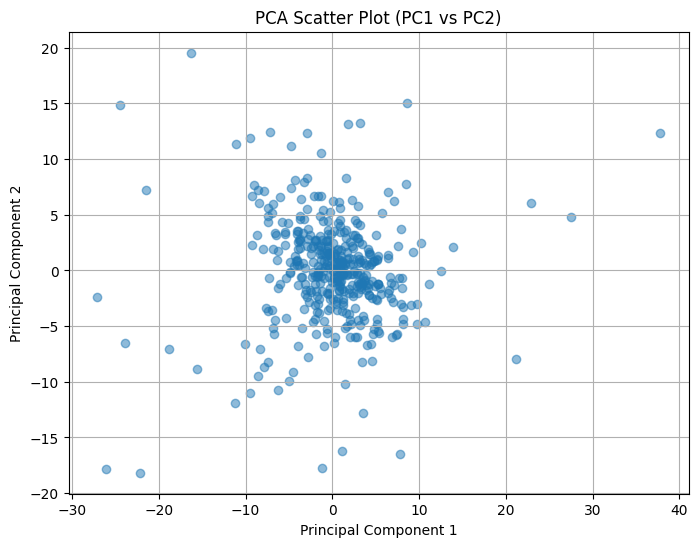

In [103]:
# Project data onto the selected principal components
projected_data = np.dot(monthly_data_scaled, selected_components.T)

# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1], alpha=0.5)
plt.title('PCA Scatter Plot (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


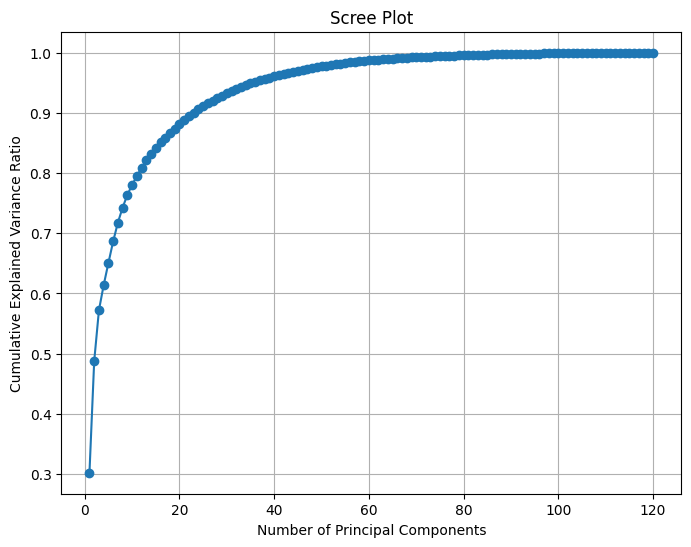

In [104]:
# monthly_data_scaled

# Scree plot to visualize explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()


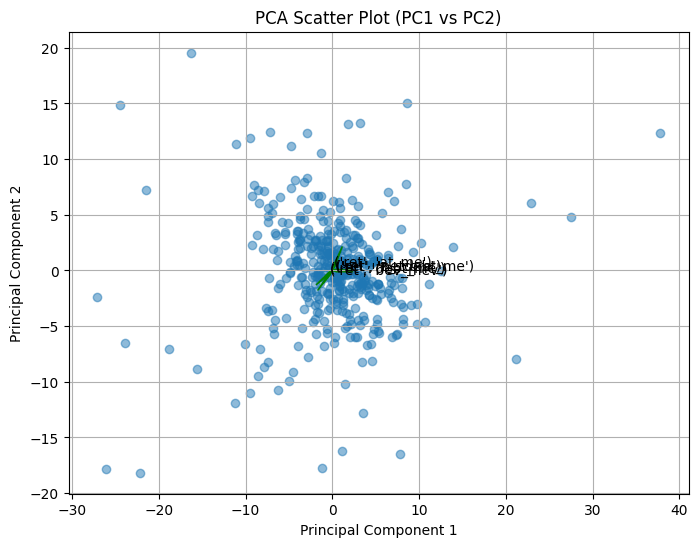

In [105]:
# Project data onto the selected principal components
projected_data = np.dot(monthly_data_scaled, selected_components.T)

# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1], alpha=0.5)
plt.title('PCA Scatter Plot (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Add directional vectors indicating feature names
for i, feature in enumerate(top_features[0][:5]):  # Consider top 5 features for PC1
    plt.arrow(0, 0, selected_components[0, i]*3, selected_components[1, i]*3, color='g', width=0.1, head_width=0.2, head_length=2)
    plt.text(selected_components[0, i]*3, selected_components[1, i]*3, feature, color='black')

plt.show()

In [106]:
for component in selected_components:
    component_loadings = pd.Series(component, index=feature_names)
    top_features.append(list(component_loadings.abs().sort_values(ascending=False).index[:5]))  # Convert tuple to list

factors_data=df_cleaned
# Calculate correlation matrix to identify factors that are highly correlated with each other
correlation_matrix = factors_data.corr().abs()

# Set a threshold for correlation coefficient to identify highly correlated factors
threshold = 0.8  # Adjust threshold as needed

# Find pairs of factors with correlation coefficient above the threshold
correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > threshold:
            correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Identify potential amalgamated factors based on correlated pairs
potential_amalgamated_factors = set()
for factor1, factor2 in correlated_pairs:
    potential_amalgamated_factors.add(factor1)
    potential_amalgamated_factors.add(factor2)

# Print potential amalgamated factors
print("Potential Amalgamated Factors:")
print(potential_amalgamated_factors)

# Filter out potential amalgamated factors from factors_data
filtered_factors_data = factors_data.drop(columns=potential_amalgamated_factors)

data_col = list(filtered_factors_data.columns)
new_cols = []
for row in data_col:
    new_cols.append(row[1])
filtered_factors_data.columns = new_cols
filtered_factors_data.columns

# Display the filtered factors data
print("\nFiltered Factors Data:")
filtered_factors_data


Potential Amalgamated Factors:
{('ret', 'size'), ('ret', 'rvol_21d'), ('ret', 'netdebt_me'), ('ret', 'inv_gr1'), ('ret', 'ret_3_1'), ('ret', 'ncoa_gr1a'), ('ret', 'prc'), ('ret', 'aliq_at'), ('ret', 'cop_at'), ('ret', 'cash_at'), ('ret', 'gp_atl1'), ('ret', 'cop_atl1'), ('ret', 'ocf_me'), ('ret', 'ivol_capm_252d'), ('ret', 'rmax1_21d'), ('ret', 'rd_sale'), ('ret', 'ni_me'), ('ret', 'ret_6_1'), ('ret', 'oaccruals_ni'), ('ret', 'eqnpo_12m'), ('ret', 'eq_dur'), ('ret', 'sale_bev'), ('ret', 'qmj_safety'), ('ret', 'short_term_reversal'), ('ret', 'mispricing_perf'), ('ret', 'op_atl1'), ('ret', 'ivol_capm_21d'), ('ret', 'at_turnover'), ('ret', 'ret_9_1'), ('ret', 'market_equity'), ('ret', 'ope_be'), ('ret', 'profitability'), ('ret', 'be_me'), ('ret', 'debt_me'), ('ret', 'beta_dimson_21d'), ('ret', 'betabab_1260d'), ('ret', 'inv_gr1a'), ('ret', 'col_gr1a'), ('ret', 'eqnpo_me'), ('ret', 'z_score'), ('ret', 'quality'), ('ret', 'low_risk'), ('ret', 'sale_me'), ('ret', 'ival_me'), ('ret', 'ocf_at'

,age,aliq_mat,chcsho_12m,corr_1260d,coskew_21d,cowc_gr1a,debt_gr3,debt_issuance,dgp_dsale,dsale_dinv,...,ret_12_7,rmax5_rvol_21d,rskew_21d,seas_1_1an,seasonality,sti_gr1a,taccruals_at,taccruals_ni,tangibility,tax_gr1a
date,,,,,,,,,,,,,,,,,,,,,
1989-05-31,0.018528,0.002404,0.059031,0.053326,-0.009608,-0.009828,-0.004670,-0.020355,-0.072002,-0.006956,...,-0.022053,0.012301,-0.000819,-0.024508,0.000217,-0.033826,-0.007579,0.028326,-0.014181,0.028983
1989-06-30,-0.050914,0.031329,0.033184,0.032228,-0.011912,0.003114,-0.002743,-0.003771,-0.068693,-0.009823,...,-0.025106,-0.019160,-0.008307,-0.006456,0.004952,-0.017378,-0.022742,-0.002891,0.002715,0.049382
1989-07-31,-0.002106,-0.018908,-0.022945,-0.066476,0.007279,0.021739,-0.000815,0.010318,-0.065385,-0.012690,...,0.015604,0.008889,0.004705,-0.000607,-0.004896,0.003275,0.003048,-0.000807,-0.030333,-0.025071
1989-08-31,-0.038128,0.031809,0.054743,0.025552,0.003285,-0.008012,0.001113,-0.021652,-0.062076,-0.015558,...,-0.038285,0.007290,0.000107,0.012964,0.002967,-0.008061,0.014770,0.031127,0.002137,0.024711
1989-09-30,-0.006802,0.005807,0.014448,0.005592,0.005341,0.004009,0.003040,-0.006955,-0.058767,-0.018425,...,-0.005526,-0.026996,-0.015052,-0.013464,-0.000178,0.006349,0.011352,0.013929,-0.028995,-0.000658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.038319,-0.006467,0.013182,0.009572,-0.001196,0.005582,0.015972,0.008514,0.009341,0.002035,...,0.011400,0.001033,0.001944,0.011250,0.001848,0.000851,-0.013000,-0.014497,0.004624,0.003478
2023-09-30,-0.029324,-0.032861,0.019092,-0.009470,-0.000870,0.003245,0.013079,0.009019,0.005173,0.009932,...,0.003119,-0.005853,0.001456,0.024011,0.000994,-0.014013,-0.011790,-0.012668,0.013173,0.006317
2023-10-31,-0.049783,0.005218,0.014277,0.003290,0.009044,0.004090,0.017473,0.008083,-0.007883,-0.006254,...,-0.007743,-0.004157,0.013128,-0.004069,-0.001044,-0.008601,-0.003853,-0.005734,0.007574,-0.003167


In [107]:
scaler = StandardScaler()
pca_filtered = PCA()
pca_filtered.fit(filtered_factors_data)

aexplained_variance_ratio = pca_filtered.explained_variance_ratio_
aselected_components = pca_filtered.components_[:5]
# aselected_components
# sum(aselected_components[0])
# aexplained_variance_ratio

In [108]:
# n_components = 5  # Example: Retain the first 5 principal components
aexplained_variance_ratio = pca_filtered.explained_variance_ratio_
aselected_components = pca_filtered.components_[:n_components]

# Step 5: Projection
aprojected_data = np.dot(filtered_factors_data, aselected_components.T)

# Optional: Create a DataFrame with the transformed data
projected_df = pd.DataFrame(data=aprojected_data, columns=[f'PC{i+1}' for i in range(n_components)])

# Print explained variance ratio
print("Explained Variance Ratio:", aexplained_variance_ratio)

aselected_components

Explained Variance Ratio: [0.2669421  0.16395947 0.07619359 0.05730313 0.05147597 0.03802002
 0.03487716 0.0317827  0.02819091 0.0226076  0.02201862 0.02008477
 0.01775992 0.01670652 0.01608388 0.01553435 0.01172264 0.01129039
 0.01098626 0.01013093 0.00896568 0.00872479 0.00641539 0.00611938
 0.00568824 0.00540605 0.00440968 0.0042078  0.00407963 0.00390692
 0.00346751 0.00321894 0.00231694 0.00230642 0.00199642 0.0015235
 0.00132537 0.00107459 0.0006942  0.00048161]


array([[ 6.93811680e-01,  2.55446208e-01, -1.98198249e-01,
         7.45001455e-02,  1.24560933e-02, -3.04028165e-02,
        -5.69091160e-02,  2.21243114e-03,  2.11690480e-02,
         2.88649904e-02, -2.58174603e-02, -9.54631289e-02,
        -2.86280781e-01, -2.72675904e-01, -4.40850777e-02,
        -5.99087187e-02, -1.92621123e-01, -4.61232323e-02,
        -2.54805348e-02, -2.39486637e-01,  3.85715806e-05,
        -1.47355162e-01, -3.59138559e-02, -2.23120412e-02,
         2.53177404e-02, -2.03265581e-02, -8.44977484e-02,
         5.46439337e-02, -8.20785061e-04, -1.10322175e-01,
         1.69719265e-01, -6.44763662e-02, -4.12167928e-02,
         1.19541904e-01, -6.70134304e-03,  5.03968699e-02,
        -3.86215688e-02, -9.87823359e-02, -1.04704026e-01,
         1.16103114e-01],
       [ 2.40295665e-01, -1.92987392e-01, -1.02640504e-01,
        -4.15214170e-01, -6.17430402e-02, -2.28315130e-02,
        -5.66773797e-02, -2.03278619e-03, -9.15184398e-02,
        -2.40325390e-02, -7.25

In [115]:
# Step 5: Get names of features with highest loadings for each principal component
afeature_names = filtered_factors_data.columns
atop_features = []
for acomponent in aselected_components:
    acomponent_loadings = pd.Series(acomponent, index=afeature_names)
    # atop_features.append([acomponent_loadings.abs().sort_values(ascending=False).index[:5], acomponent_loadings.abs().sort_values(ascending=False)[:5]])  # Get top 5 features with highest loadings
    atop_features.append(acomponent_loadings.abs().sort_values(ascending=False)[:10])  # Get top 5 features with highest loadings

for i in range(len(atop_features)):
    print(i, atop_features[i])
# filtered_factors_data.columns

importance = {}
for i in afeature_names:
    importance[i] = 0
    for ser in atop_features:
        try:
            importance[i] += ser.loc[i]
        except:
            importance[i] += 0
importance_sorted = {k: v for k, v in sorted(importance.items(), key=lambda item: item[1])}


0 age           0.693812
eqnetis_at    0.286281
fcf_me        0.272676
aliq_mat      0.255446
netis_at      0.239487
chcsho_12m    0.198198
kz_index      0.192621
ret_12_7      0.169719
o_score       0.147355
seas_1_1an    0.119542
dtype: float64
1 ret_12_7         0.514719
rd_me            0.425526
corr_1260d       0.415214
ebit_sale        0.241034
age              0.240296
seas_1_1an       0.230706
o_score          0.207348
aliq_mat         0.192987
tax_gr1a         0.164268
profit_growth    0.155289
dtype: float64
2 corr_1260d        0.521515
aliq_mat          0.404586
age               0.339487
kz_index          0.279175
o_score           0.259189
rmax5_rvol_21d    0.210617
ebit_sale         0.197863
netis_at          0.185631
tangibility       0.165997
eqnetis_at        0.149782
dtype: float64
3 ret_12_7       0.593257
corr_1260d     0.453628
seas_1_1an     0.367594
aliq_mat       0.350078
ppeinv_gr1a    0.177363
rd_me          0.148337
ebit_sale      0.142989
chcsho_12m     0.13

In [110]:
important_factors = list(importance_sorted.items())[-20:]
important_factors_list = []
for tup in important_factors:
    important_factors_list.append(tup[0])

for i in atop_features:
    for j in range(len(list(i.index))):
        if list(i.index)[j] not in important_factors_list:
            print(list(i.index)[j])
important_factors

profit_growth
noa_at


[('cowc_gr1a', 0.18506640287115023),
 ('tax_gr1a', 0.2778228823282733),
 ('chcsho_12m', 0.3306371152130011),
 ('dgp_dsale', 0.3341734488750458),
 ('tangibility', 0.3909042091258319),
 ('qmj_growth', 0.4317198939794481),
 ('eqnetis_at', 0.436063246427539),
 ('ppeinv_gr1a', 0.45024245037316657),
 ('rmax5_rvol_21d', 0.474352334364622),
 ('fcf_me', 0.4961492263629269),
 ('rd_me', 0.5738628320919299),
 ('ebit_sale', 0.5818857179040349),
 ('o_score', 0.6138920469825332),
 ('netis_at', 0.6763617834247944),
 ('kz_index', 0.7160743494392707),
 ('seas_1_1an', 0.717842187962691),
 ('age', 1.2735942768713093),
 ('ret_12_7', 1.2776945582561994),
 ('corr_1260d', 1.3903563538676853),
 ('aliq_mat', 1.524774472664033)]

In [111]:
factor_world_weighting_monthly.to_csv("hellpo",index=False)
pivot_df = factor_world_weighting_monthly.pivot(index='date', columns='factors', values='ret')
factor_world_weighting_monthly['date'] = pd.to_datetime(factor_world_weighting_monthly['date'])

# atop_features